In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, CategoricalParameter, Constant
import time

In [10]:
seeds = [259572, 7542, 864199, 11540, 188813, 411862, 546078, 420812, 304196, 814030]

In [11]:
load=1
seed=seeds[0]
r=50000
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, routes_supported, extra_nodes_used = flow_refueling_location_model(load, seed, r, 40, 600, 2, 0)

Optimal


In [12]:
print(total_flow, fraction_captured_total, serviceable_fraction, served_fraction, routes_supported, extra_nodes_used)

1263.7549119373778 0.20072186939806194 0.26187234773717233 0.7664874551761228 30.0 0.0


In [13]:
#define model
model = Model("frlm", function=flow_refueling_location_model)

In [14]:
#define parameters
model.constants = [
    Constant("load", 1),
    Constant('stations_to_place', 40),
    Constant('station_cap', 600),
    Constant('max_per_loc', 2)
]

model.uncertainties = [
    CategoricalParameter("seed", seeds),
    CategoricalParameter("r", [50000, 60000, 70000, 80000, 90000, 100000]),
]

# set levers
model.levers = [
    CategoricalParameter("additional_nodes", [0, 1, 2, 3]),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("fraction_captured_total"),
    ScalarOutcome("serviceable_fraction"),
    ScalarOutcome("served_fraction"),
    ScalarOutcome("routes_supported"),
    ScalarOutcome("extra_nodes_used"),
]

In [15]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model, n_processes=20) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=60, policies=4)

[MainProcess/INFO] pool started with 20 workers
[MainProcess/INFO] performing 60 scenarios * 4 policies * 1 model(s) = 240 experiments
100%|████████████████████████████████████████| 240/240 [06:40<00:00,  1.67s/it]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [3]:
# pickle.dump( experiments, open( "results/experiments_batch_run606.p", "wb" ) )
# pickle.dump( outcomes, open("results/outcomes_batch_run606.p", "wb") )

experiments = pickle.load(open("results/experiments_batch_run606.p", "rb"))
outcomes = pickle.load(open("results/outcomes_batch_run606.p", "rb"))

In [16]:
experiments

,r,seed,additional_nodes,scenario,policy,model
0,70000,304196,0,4,0,frlm
1,60000,420812,0,5,0,frlm
2,100000,7542,0,6,0,frlm
3,90000,420812,0,7,0,frlm
4,50000,259572,0,8,0,frlm
...,...,...,...,...,...,...
235,50000,814030,3,59,3,frlm
236,100000,411862,3,60,3,frlm
237,60000,7542,3,61,3,frlm
238,100000,814030,3,62,3,frlm


In [17]:
df = pd.merge(experiments,pd.DataFrame(outcomes), left_index=True, right_index=True)

In [18]:
df

,r,seed,additional_nodes,scenario,policy,model,total_flow,fraction_captured_total,serviceable_fraction,served_fraction,routes_supported,extra_nodes_used
0,70000,304196,0,4,0,frlm,1259.538630,0.255765,0.310559,0.823562,32.0,0.0
1,60000,420812,0,5,0,frlm,1257.800548,0.242486,0.300828,0.806063,30.0,0.0
2,100000,7542,0,6,0,frlm,1258.812290,0.265219,0.442695,0.599100,38.0,0.0
3,90000,420812,0,7,0,frlm,1257.800548,0.251695,0.371225,0.678013,37.0,0.0
4,50000,259572,0,8,0,frlm,1263.754912,0.200722,0.261872,0.766487,30.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
235,50000,814030,3,59,3,frlm,1259.664579,0.232915,0.663592,0.350991,32.0,7.0
236,100000,411862,3,60,3,frlm,1255.703249,0.268752,0.717659,0.374484,36.0,1.0
237,60000,7542,3,61,3,frlm,1258.812290,0.253551,0.644363,0.393491,33.0,9.0
238,100000,814030,3,62,3,frlm,1259.664579,0.268759,0.722463,0.372004,35.0,1.0


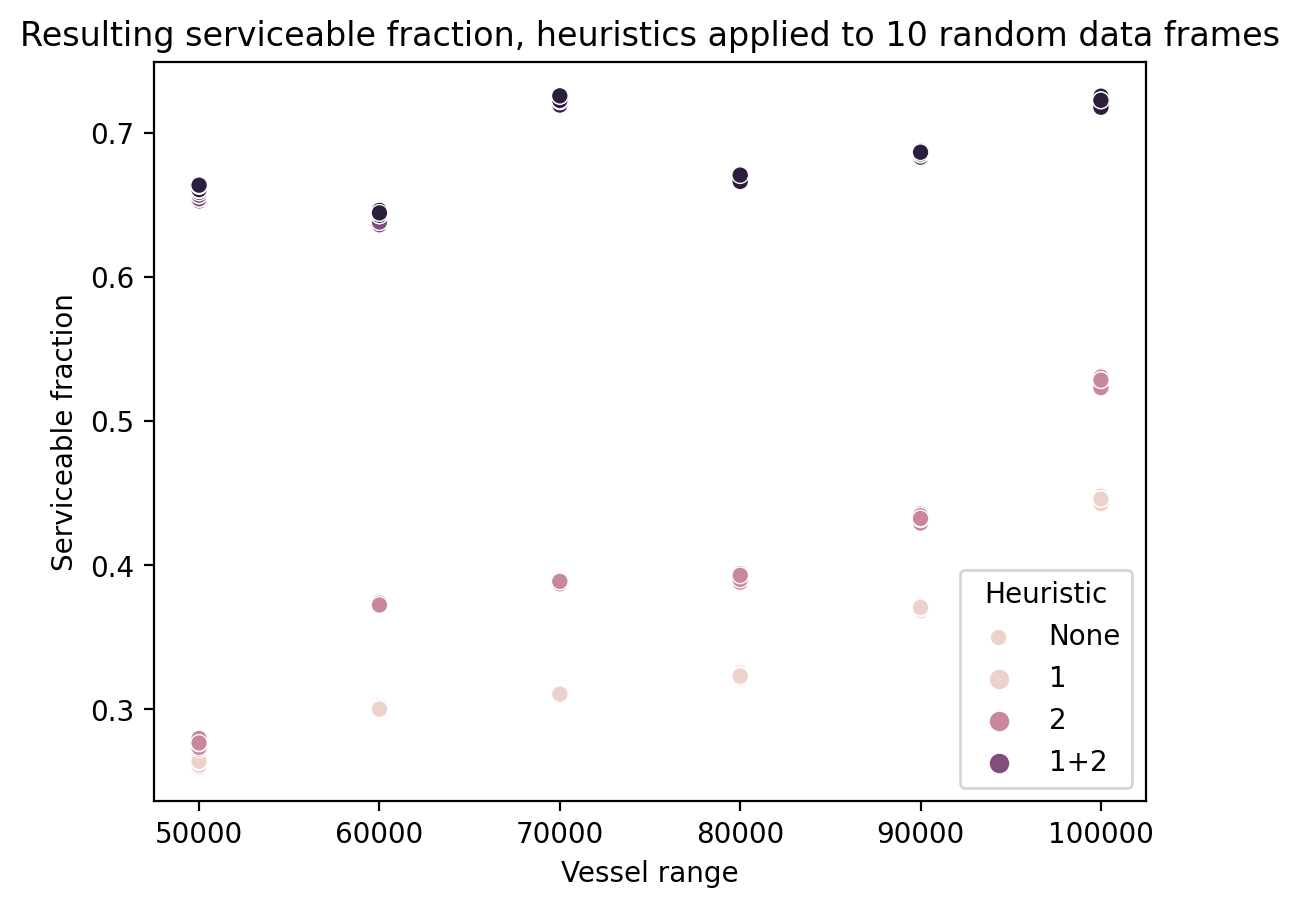

In [19]:
fig, ax = plt.subplots(dpi=200)
sns.scatterplot(x='r', y='serviceable_fraction', hue='policy', data=df, ax=ax)
plt.title("Resulting serviceable fraction, heuristics applied to 10 random data frames")
plt.ylabel("Serviceable fraction")
plt.xlabel("Vessel range")
plt.legend(title="Heuristic", labels=["None", "1", "2", "1+2"])
plt.show()

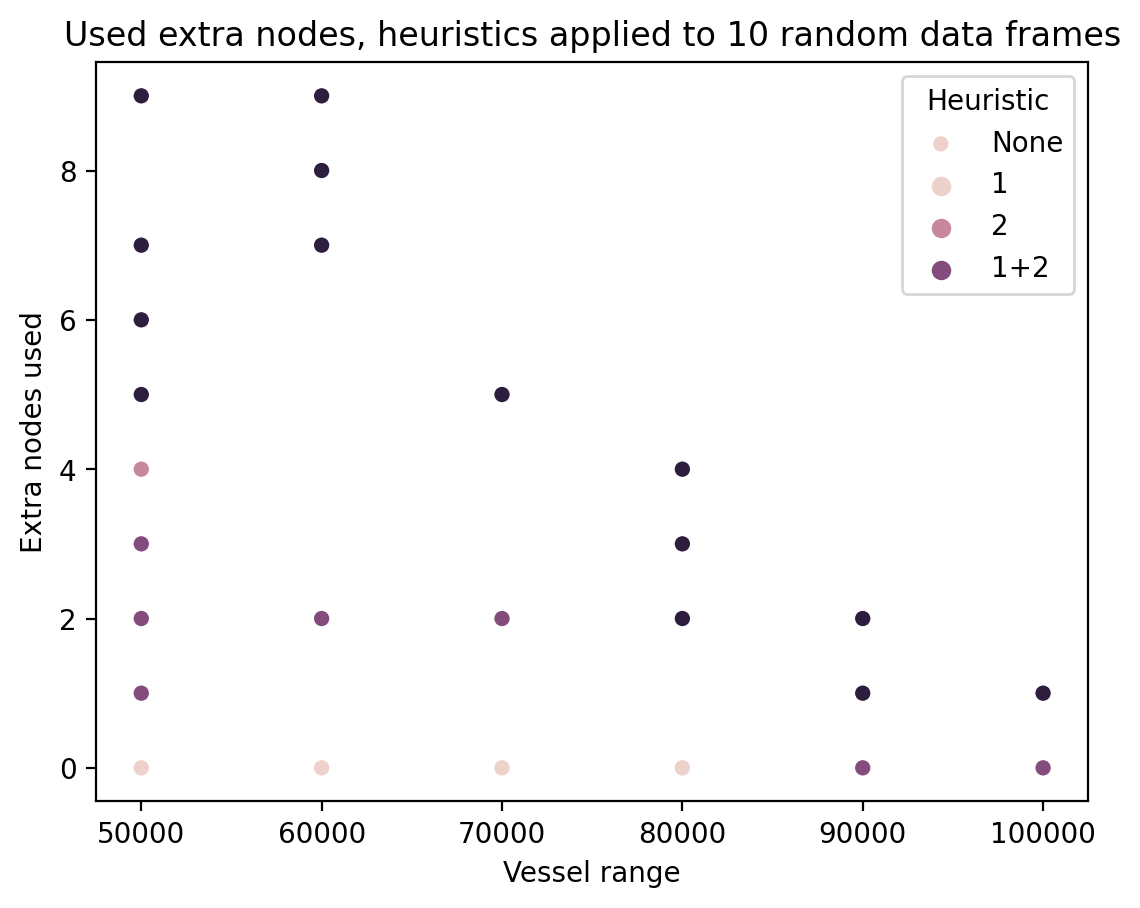

In [24]:
plt.subplots(dpi=200)
sns.scatterplot(x='r', y='extra_nodes_used', hue='additional_nodes', data=df)
plt.title("Used extra nodes, heuristics applied to 10 random data frames")
plt.ylabel("Extra nodes used")
plt.xlabel("Vessel range")
plt.legend(title="Heuristic", labels=["None", "1", "2", "1+2"])

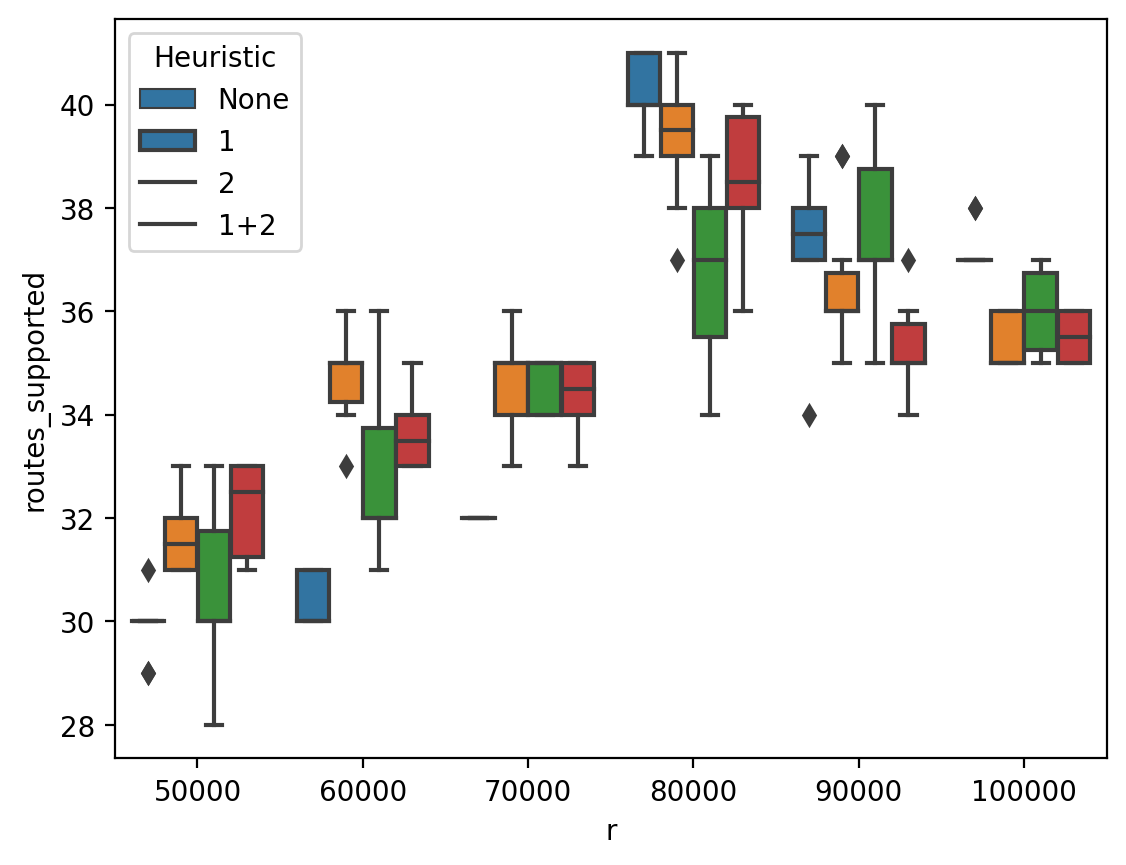

In [22]:
plt.subplots(dpi=200)
sns.boxplot(x='r', y='routes_supported', hue='additional_nodes', data=df)
plt.legend(title="Heuristic", labels=["None", "1", "2", "1+2"])


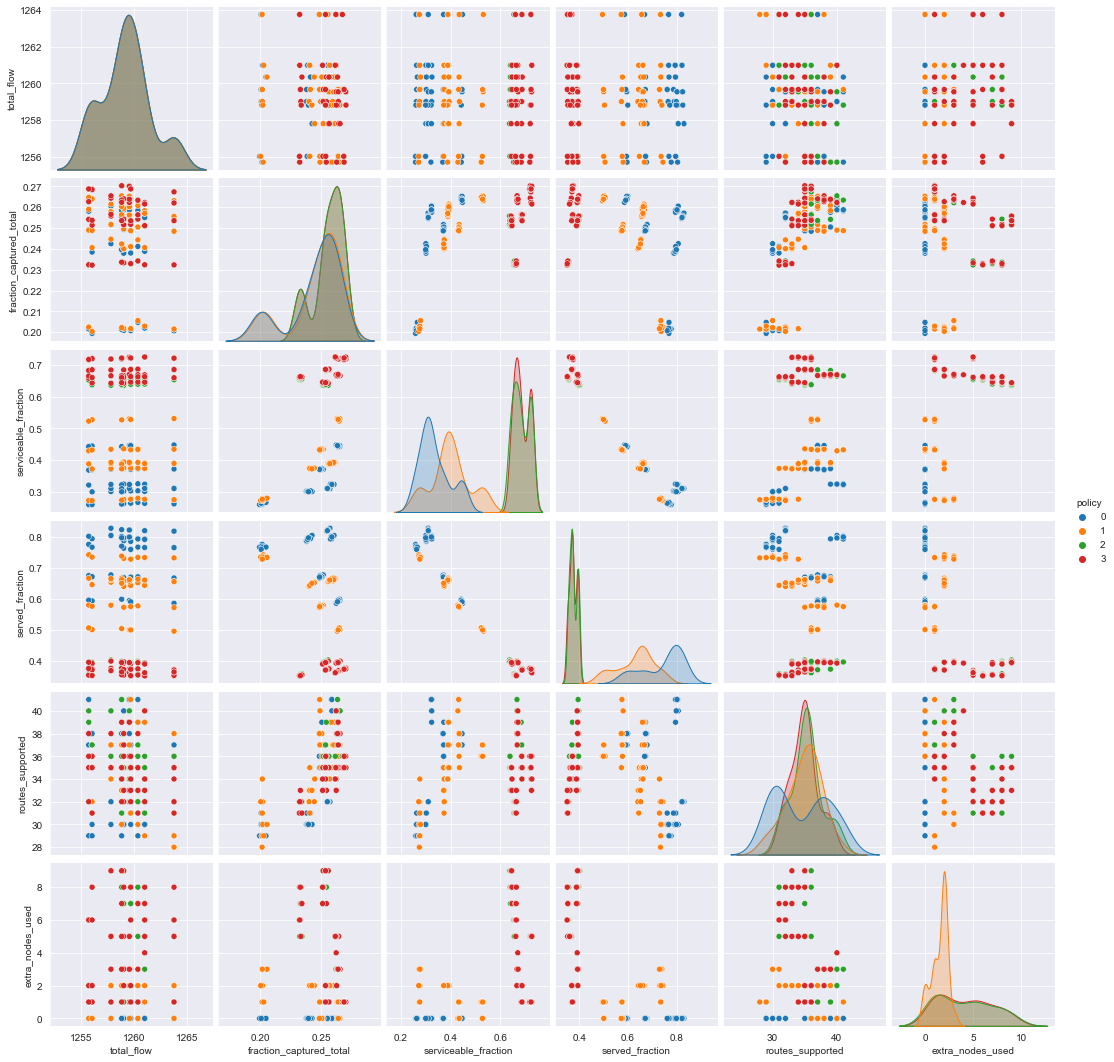

In [16]:
policies = experiments["policy"]
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies == policy, "policy"] = str(i)

data = pd.DataFrame(outcomes)
data["policy"] = policies
sns.pairplot(data, hue="policy", vars=list(outcomes.keys()))
plt.show()

[MainProcess/INFO] model dropped from analysis because only a single category
C:\Users\Fabia\Anaconda3\envs\ox\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
[MainProcess/INFO] model dropped from analysis because only a single category
C:\Users\Fabia\Anaconda3\envs\ox\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Fabia\Anaconda3\envs\ox\lib\site-packages\ema_workbench\analysis\feature_scoring.py:389: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete = complete.append(fs.T, sort=True)
[MainProcess/INFO] model dropped from analysis because only a single category
C:\Users\Fabia\Anac

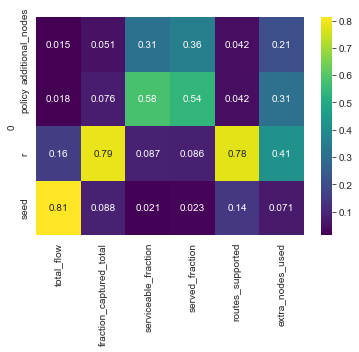

In [17]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()